In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import HistGradientBoostingClassifier

# from imblearn.over_sampling import SMOTE, ADASYN
# from imblearn.under_sampling import RandomUnderSampler, TomekLinks
# from imblearn.combine import SMOTETomek

from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize

from sklearn.preprocessing import OneHotEncoder

# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [ ]:
N_ITERATIONS = 500 # TODO: increase when trying fr
TOLERANCE = 0.1 # TODO: change if scoring changed from accuracy (normally 1e-4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = pd.read_csv("X_train.csv").values
y = pd.read_csv("y_train.csv").squeeze()

# Scaled later in the pipeline.
scaler = StandardScaler()
# X = scaler.fit_transform(X)

# classes_to_remove = [5, 6, 14, 17]
# mask = ~np.isin(y, classes_to_remove)
# X = X[mask]
# y = y[mask]

le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
classes = np.unique(y)
y_one_hot = label_binarize(y, classes=classes) # TODO: investigate TransformedTargetRegressor? https://scikit-learn.org/stable/modules/compose.html#transforming-target-in-regression
# class_counts = np.sum(y_one_hot, axis=0)
# class_weights = 1.0 / class_counts
# class_weights /= np.sum(class_weights)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=4)

In [ ]:
# Basic logistic regression
logistic = LogisticRegression(
    max_iter=N_ITERATIONS,
    multi_class='multinomial',
    solver='lbfgs',
    penalty=None,
    tol=TOLERANCE,
    # class_weight='balanced' if config.use_weights else None
)

lr_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("reduce_dim", "passthrough"),
    ("classifier", logistic),

])

# Logistic regression with grid search over C values + l2 regularisation
C_OPTIONS = np.logspace(-4, 4, 4)
lr_basic_cv_param_grid = {
    "classifier__penalty": ["l2"],
    "classifier__C": C_OPTIONS,
}

# TODO: perhaps use weighted ... as scoring?
# -> https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
lr_basic_cv = GridSearchCV(lr_pipe, lr_basic_cv_param_grid, n_jobs=-1)

# Logistic regression with PCA + grid search over C values & number of features
# See:
# - https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py
# - https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py
# N_FEATURES_OPTIONS = [5, 10, 25, 50, 100, 150, 200, 300]
N_FEATURES_OPTIONS = np.geomspace(10, 300, num=10).astype(int)
lr_pca_param_grid = {
    # TODO: test NMF, SelectKBest(mutual_info_classif) etc, & figure out how to plot
    "reduce_dim": [PCA()],
    "reduce_dim__n_components": N_FEATURES_OPTIONS,
    "classifier__penalty": ["l2"],
    "classifier__C": C_OPTIONS,
}

lr_pca = GridSearchCV(lr_pipe, lr_pca_param_grid, n_jobs=-1)

In [ ]:
# TODO: include feature selection method in GridSearchCV, rather than `experiments`
# https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py


# Maps experiment name to the estimator (pipeline)
experiments = {
  # Logistic Regression
  'LR - Baseline (no penalty)': lr_pipe,
  'LR - Basic grid search of C values + l2 penalty': lr_basic_cv,
  'LR - PCA + grid search of C & # features': lr_pca,
  # TODO: more experiment types
}

results = {}
predictions = {}
probabilities = {}

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

for name, estimator in experiments.items():
    print(f"Training: {name}")

    # Fit the model
    estimator.fit(X_train, y_train)

    # Predict
    y_pred = estimator.predict(X_test)
    y_proba = estimator.predict_proba(X_test)

    predictions[name] = y_pred
    probabilities[name] = y_proba


Training: LR - Baseline (no penalty)
Training: LR - Basic grid search of C values + l2 penalty
Training: LR - PCA + grid search of C & # features


In [ ]:
def weighted_log_loss(y_true, y_pred_proba):
    # One-hot encode y_true
    # TODO: use LabelBinzarizer instead??
    ohe = OneHotEncoder(sparse_output=False, categories='auto', handle_unknown='ignore')
    y_true = np.array(y_true).reshape(-1, 1)
    y_true_bin = ohe.fit_transform(y_true)

    # Compute class weights (inverse frequency, normalized)
    class_counts = np.sum(y_true_bin, axis=0)
    class_weights = 1.0 / class_counts
    class_weights /= np.sum(class_weights)

    # Compute sample weights using the one-hot labels and class weights
    sample_weights = np.sum(y_true_bin * class_weights, axis=1)

    # Compute weighted log loss
    eps = 1e-15  # To avoid log(0)
    loss = -np.mean(sample_weights * np.sum(y_true_bin * np.log(np.clip(y_pred_proba, eps, 1)), axis=1))
    return loss


Evaluation Metrics for Each Method:
LR - Baseline (no penalty) | Macro F1: 0.1681 | Weighted Log Loss: 0.0098
LR - Basic grid search of C values + l2 penalty | Macro F1: 0.1681 | Weighted Log Loss: 0.0098
LR - PCA + grid search of C & # features | Macro F1: 0.2527 | Weighted Log Loss: 0.0093


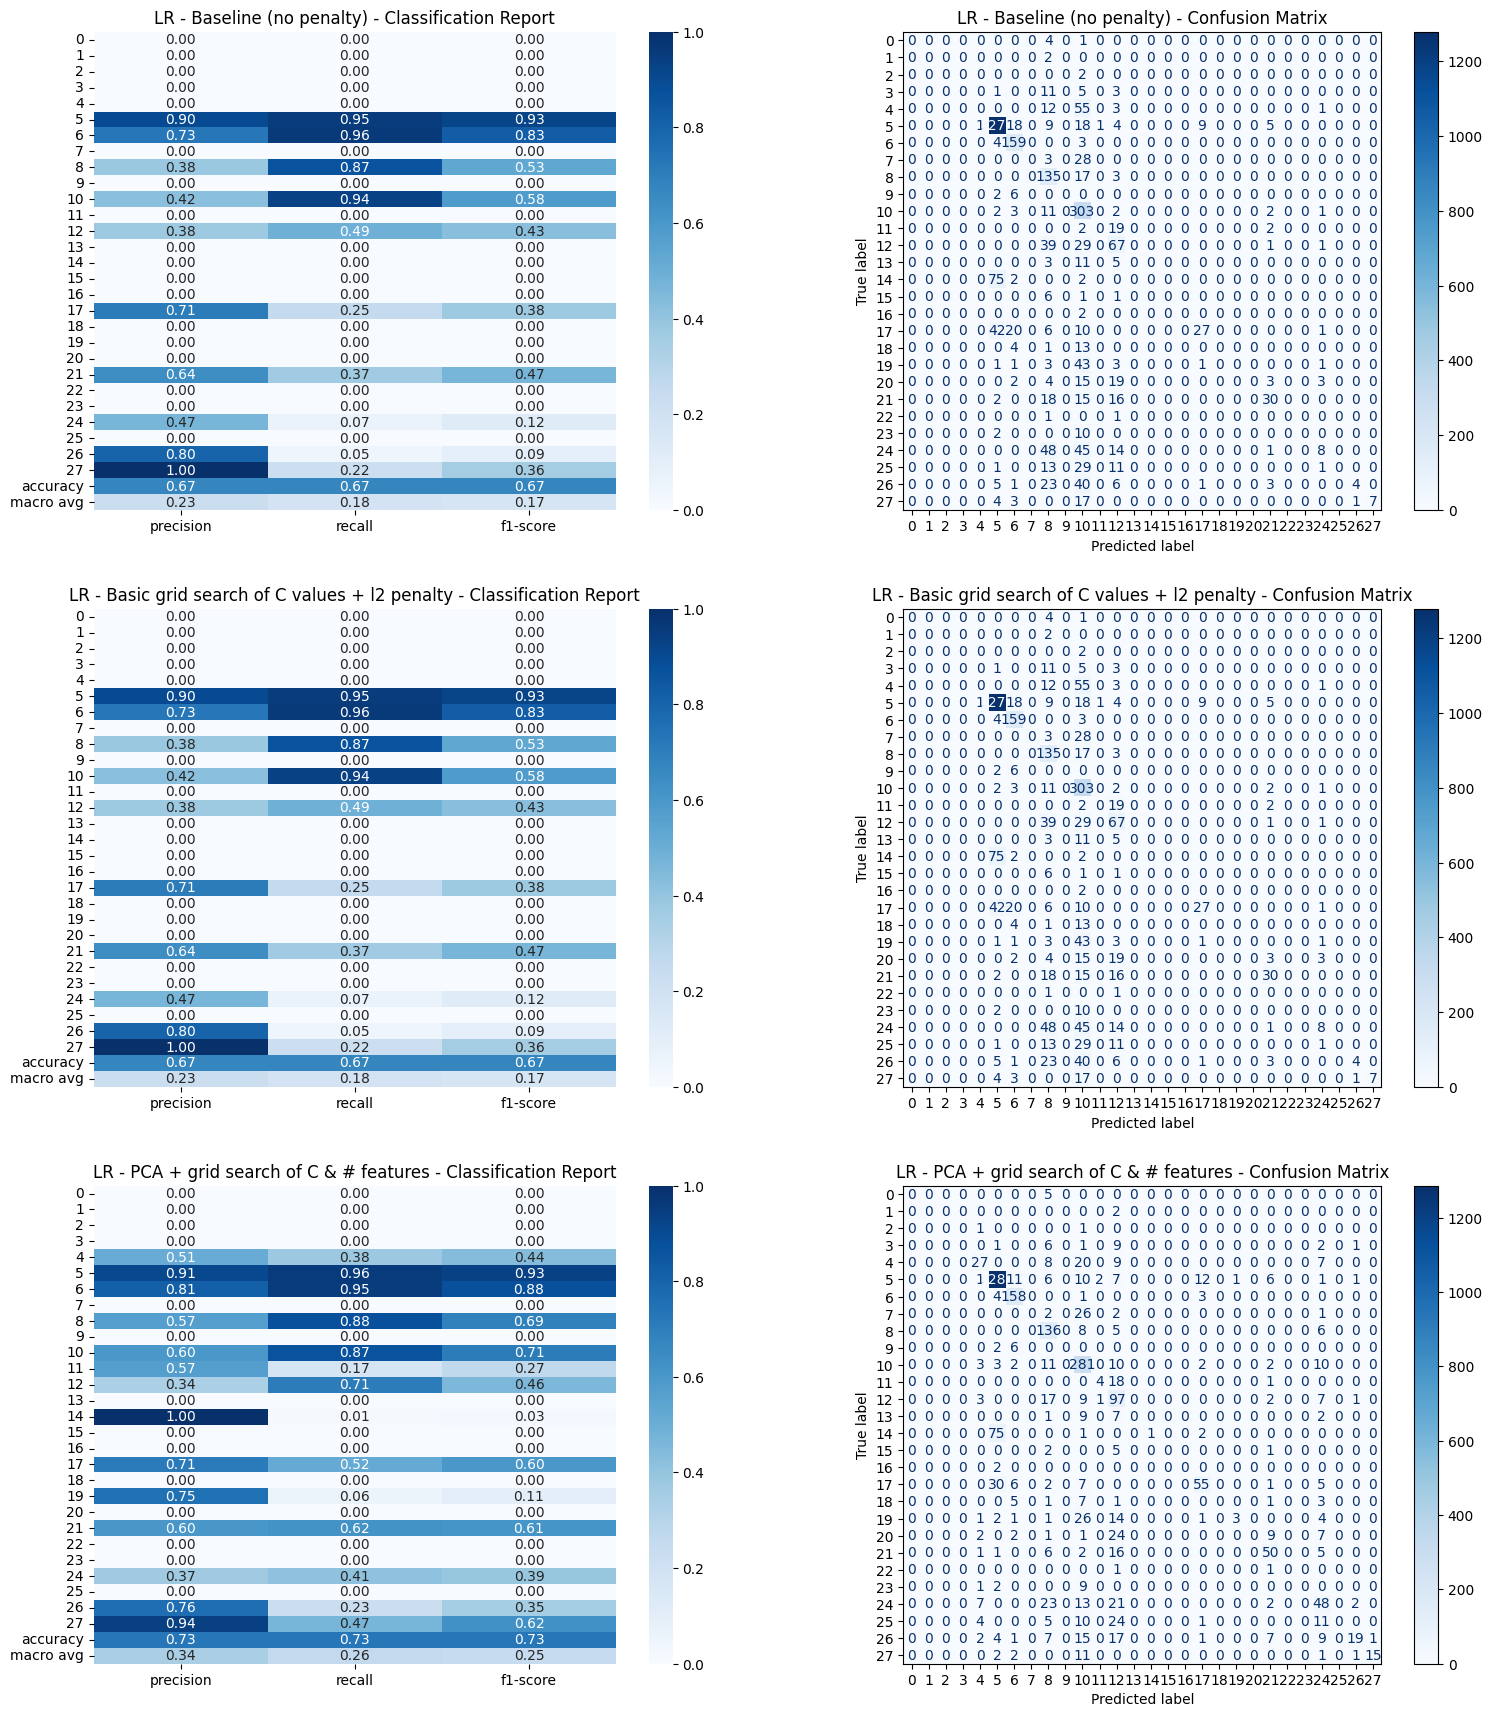

In [ ]:
print("\nEvaluation Metrics for Each Method:")
for method in predictions:
    y_pred = predictions[method]
    y_proba = probabilities[method]

    f1 = f1_score(y_test, y_pred, average='macro')
    wll = weighted_log_loss(y_test, y_proba) # TODO: fix it being very off

    results[method] = (f1, wll)
    print(f"{method:25s} | Macro F1: {f1:.4f} | Weighted Log Loss: {wll:.4f}")

# fig, axes = plt.subplots(len(predictions), 2, figsize=(16, 6 * len(predictions)))
fig, axes = plt.subplots(len(predictions), 2, figsize=(16, 6 * len(predictions)))
fig.tight_layout(pad=5.0)

for idx, (method, y_pred_vals) in enumerate(predictions.items()):
    report = classification_report(y_test, y_pred_vals, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues", ax=axes[idx, 0])
    axes[idx, 0].set_title(f"{method} - Classification Report")

    cm = confusion_matrix(y_test, y_pred_vals)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=axes[idx, 1], cmap="Blues", values_format='d')
    axes[idx, 1].set_title(f"{method} - Confusion Matrix")

plt.show()


# More dimensionality reduction tests

## PCA + logistic regression grid search

Modified from [this sklearn example](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py)

Might have to add a penalty for more components if conducting a grid search..? Although I guess we just want the best performance, we don't really care about training time for this assignment.

Best parameter (CV score=0.728):
{'logistic__C': np.float64(0.046415888336127774), 'pca__n_components': np.int64(300)}


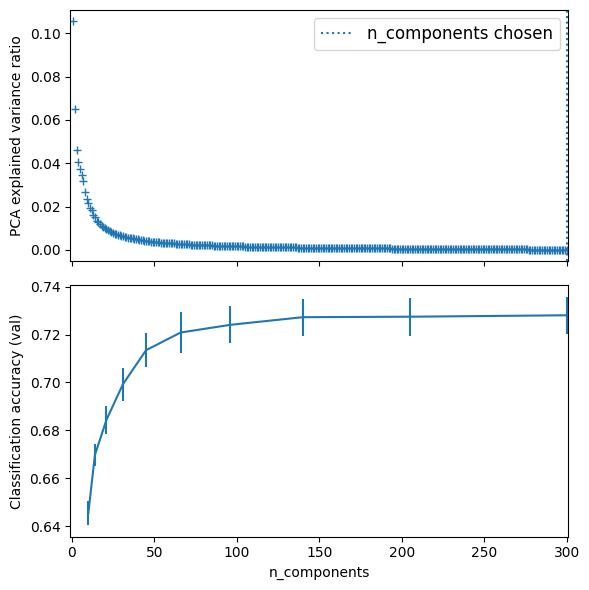

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

# X_digits, y_digits = datasets.load_digits(return_X_y=True) # TODO
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    # "pca__n_components": [5, 15, 30, 45, 60],
    "pca__n_components": N_FEATURES_OPTIONS,
    # "logistic__C": np.logspace(-4, 4, 4),
    "logistic__C": C_OPTIONS,
}
search = GridSearchCV(pipe, param_grid, n_jobs=2) # TODO: change scoring function
search.fit(X, y) ## don't bother with X/y_train - automatically performs CV
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
components_col = "param_pca__n_components"
is_max_test_score = pl.col("mean_test_score") == pl.col("mean_test_score").max()
best_clfs = (
    pl.LazyFrame(search.cv_results_)
    .filter(is_max_test_score.over(components_col))
    .unique(components_col)
    .sort(components_col)
    .collect()
)
ax1.errorbar(
    best_clfs[components_col],
    best_clfs["mean_test_score"],
    yerr=best_clfs["std_test_score"],
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

# plt.xlim(-1, 70)
plt.xlim(-1, 301)

plt.tight_layout()
plt.show()

It looks like PCA can reduce the dimensions from 300 to 200 with negligible impact to accuracy/F1/log-loss. Even 100/150 work well - this makes sense, as 174 principle components account for 95% of the variance in X, and the first 123 principle components account for 90% of the variance in X.

## Logistic regression + grid search over dimension reduction strategies (`PCA`, `NMF`, `SelectKBest(mutual_info_classif)`)

Modified from [this sklearn example](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py), using logistic regression rather than `LinearSVC` to start with. Other models could/should be compared too.

In [ ]:
# from sklearn.decomposition import NMF, PCA
# from sklearn.feature_selection import SelectKBest, mutual_info_classif
# # from sklearn.preprocessing import MinMaxScaler
# # from sklearn.svm import LinearSVC

# logistic = LogisticRegression(
#     max_iter=N_ITERATIONS,
#     multi_class='multinomial',
#     solver='lbfgs',
#     # penalty=None,
#     tol=TOLERANCE,
#     # class_weight='balanced' if config.use_weights else None
# )

# pipe = Pipeline(
#     [
#         # ("scaling", MinMaxScaler()),
#         ("scaling", StandardScaler()),
#         # the reduce_dim stage is populated by the param_grid
#         ("reduce_dim", "passthrough"),
#         # ("classify", LinearSVC(dual=False, max_iter=10000)),
#         ("classify", logistic),
#     ]
# )

# # TODO: test feature agglomeration etc
# # - https://scikit-learn.org/stable/modules/unsupervised_reduction.html#feature-agglomeration
# # - https://scikit-learn.org/stable/auto_examples/cluster/plot_feature_agglomeration_vs_univariate_selection.html#sphx-glr-auto-examples-cluster-plot-feature-agglomeration-vs-univariate-selection-py
# # - https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html#sphx-glr-auto-examples-compose-plot-feature-union-py

# # N_FEATURES_OPTIONS = [2, 4, 8]
# # C_OPTIONS = [1, 10, 100, 1000]
# param_grid = [
#     {
#         # "reduce_dim": [PCA(iterated_power=7), NMF(max_iter=1_000)],
#         # "reduce_dim": [PCA(), NMF()],
#         "reduce_dim": [PCA()],
#         "reduce_dim__n_components": N_FEATURES_OPTIONS,
#         "classify__C": C_OPTIONS,
#     },
#     # {
#         # "reduce_dim": [SelectKBest(mutual_info_classif)],
#         # "reduce_dim__k": N_FEATURES_OPTIONS,
#         # "classify__C": C_OPTIONS,
#     # },
# ]
# reducer_labels = ["PCA", "NMF", "KBest(mutual_info_classif)"]

# # TODO: score using weighted log loss
# grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
# grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        LogisticRegression(max_iter=500,
                                                           multi_class='multinomial',
                                                           tol=0.1))]),
             n_jobs=1,
             param_grid=[{'classify__C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                          'reduce_dim': [PCA()],
                          'reduce_dim__n_components': array([ 10,  14,  21,  31,  45,  66,  96, 140, 205, 300])}])

In [ ]:
# mean_scores = np.array(grid.cv_results_["mean_test_score"])
# # scores are in the order of param_grid iteration, which is alphabetical
# mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# # select score for best C
# mean_scores = mean_scores.max(axis=0)
# # create a dataframe to ease plotting
# mean_scores = pd.DataFrame(
#     mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
# )

# ax = mean_scores.plot.bar()
# ax.set_title("Comparing feature reduction techniques")
# ax.set_xlabel("Reduced number of features")
# ax.set_ylabel("Digit classification accuracy")
# ax.set_ylim((0, 1))
# ax.legend(loc="upper left")

# plt.show()

ValueError: Shape of passed values is (10, 1), indices imply (10, 3)

# TODO: test other feature selection / dimensionality reduction methods